In [29]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from datetime import datetime

# Configure matplotlib for LaTeX rendering
plt.rcParams.update({
    'text.usetex': False,  # Disable LaTeX to use system fonts
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],  # Impact first, fallbacks
    'font.size': 20,
    'axes.labelsize': 25,
    'axes.titlesize': 25,
    'legend.fontsize': 25,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'figure.titlesize': 30,
    'pgf.rcfonts': False,  # Use LaTeX default fonts for PGF
    'pgf.preamble': r'\usepackage{amsmath}\usepackage{amsfonts}'
})

from plot.multicurve import MultiCurvePlotter
from plot.log_dual_plot import LogDualPlot

from core.nodes.transmission_node import TransmissionNode
from core.nodes.computing_node import ComputingNode

# Complete Offloading

- No computing on User Satellite in Offloading case
- Variation of $\phi_\text{ec}$
- Ratio $S_\text{isl} / S_\text{gl}$

In [30]:
with_legend = True
plot_precision = 1000

data_size = 100
phi_min = 0.0  # Minimum phi value
phi_max = 1.5  # Maximum phi value


In [31]:
config = {
    "base": {
        "obdh": {
            "speed": 30.0,
            "phi": 0.9,
            "energy_uptime": 1,
            "energy_io": 0.001
        },
        "ground_link": {
            "speed": 10.0,
            "energy": 5,
            "distance": 700
        }
    },
    "offloading": {
        "user_satellite": {
            "obdh": { # No computing on the user satellite in this scenario
                "phi": None,
                "speed": None,
                "energy_uptime": None,
                "energy_io": None
            },
            "isl": {
                "speed": None, # Exploring ISL speed variation
                "energy": 3,
                "distance": 100
            }
        },
        "edge_node": {
            "edge_computer": {
                "phi": None, # Exploring EC phi variation
                "speed": 300.0,
                "energy_uptime": 50,
                "energy_io": 0.001
            },
            "ground_link": {
                "speed": None, # Exploring GL speed variation
                "energy": 5,
                "distance": 700
            }
        }
    }
}

# Base Case

- Computing on User Satellite (OBDH)
- Ground Link

In [32]:
base_obdh_speed = config['base']['obdh']['speed']
base_odbh_phi = config['base']['obdh']['phi']
base_obdh_energy_uptime = config['base']['obdh']['energy_uptime']
base_obdh_energy_io = config['base']['obdh']['energy_io']

# Base Case - calculate reference costs
base_time_cost = 0
base_energy_cost = 0

obc = ComputingNode(
    speed=base_obdh_speed,
    phi=base_odbh_phi
)

base_time_cost += obc.time_cost(data_size)
base_energy_cost += obc.energy_cost(
    data_size,
    energy_uptime=base_obdh_energy_uptime,
    energy_io=base_obdh_energy_io
)

d_out_obc = obc.process(data_size)

base_ground_link_speed = config['base']['ground_link']['speed']
base_ground_link_energy = config['base']['ground_link']['energy']
base_ground_link_distance = config['base']['ground_link']['distance']

ground_link = TransmissionNode(
    speed=base_ground_link_speed
)

base_time_cost += ground_link.time_cost(d_out_obc)
base_energy_cost += ground_link.energy_cost(
    d_out_obc,
    energy=base_ground_link_energy,
    distance=base_ground_link_distance
)

print(f"Base case - Time: {base_time_cost:.3f}s, Energy: {base_energy_cost:.3f}J")

Base case - Time: 12.333s, Energy: 131.463J


In [33]:
n_satellites = range(1, 10, 1)
phi_values = np.linspace(0.1, 1.5, 15)

s_isl = base_ground_link_speed * 1.6
print(f"N satelites : {n_satellites}")
print(f"Satellite phi: {phi_values}")
print(f"s_isl : {s_isl}")

N satelites : range(1, 10)
Satellite phi: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]
s_isl : 16.0


# Offloading Case

- No computing on User Satellite
- ISL to Edge Node
- Computing on Edge Node
- Edge Node ground link

In [34]:
time_costs = [[] for _ in range(len(n_satellites))]
energy_costs = [[] for _ in range(len(n_satellites))]

# Variation of Usr ISL
# isl_speed = config['offloading']['user_satellite']['isl']['speed']
off_isl_energy = config['offloading']['user_satellite']['isl']['energy']
off_isl_distance = config['offloading']['user_satellite']['isl']['distance']

off_edge_computer_speed = config['offloading']['edge_node']['edge_computer']['speed']
# Variation of EC phi
# edge_computer_phi = config['offloading']['edge_node']['edge_computer']['phi']
off_edge_computer_energy_uptime = config['offloading']['edge_node']['edge_computer']['energy_uptime']
off_edge_computer_energy_io = config['offloading']['edge_node']['edge_computer']['energy_io']

# Variation of EN gl
# off_ground_link_speed = config['offloading']['edge_node']['ground_link']['speed']
off_ground_link_energy = config['offloading']['edge_node']['ground_link']['energy']
off_ground_link_distance = config['offloading']['edge_node']['ground_link']['distance']

print("Computing cost grid...")

# ISL transmission
isl = TransmissionNode(speed=float(s_isl))
after_isl_iteration_time_cost = isl.time_cost(data_size)
after_isl_iteration_energy_cost = isl.energy_cost(
    data_size,
    energy=off_isl_energy,
    distance=off_isl_distance
)

for i, n in enumerate(n_satellites):
    for j, phi_en in enumerate(phi_values):
        print(f"Satellite {n}...")

        d_out_isl = isl.process(data_size)

        edge_computer = ComputingNode(
            speed=off_edge_computer_speed,
            phi=phi_en
        )

        iteration_time_cost = after_isl_iteration_time_cost + edge_computer.time_cost(d_out_isl)
        iteration_energy_cost = after_isl_iteration_energy_cost + edge_computer.energy_cost(
            d_out_isl,
            energy_uptime=off_edge_computer_energy_uptime,
            energy_io=off_edge_computer_energy_io
        )

        d_out_ec = edge_computer.process(d_out_isl)

        if n > 1:
            for _ in range(n-1):
                # Edge computing with current phi value
                edge_computer = ComputingNode(
                    speed=off_edge_computer_speed,
                    phi=phi_en
                )

                iteration_time_cost += edge_computer.time_cost(d_out_ec)
                iteration_energy_cost += edge_computer.energy_cost(
                    d_out_ec,
                    energy_uptime=off_edge_computer_energy_uptime,
                    energy_io=off_edge_computer_energy_io
                )

                d_out_ec = edge_computer.process(d_out_ec)

                en_isl = TransmissionNode(speed=float(s_isl))
                iteration_time_cost += en_isl.time_cost(d_out_ec)
                iteration_energy_cost += en_isl.energy_cost(
                    d_out_ec,
                    energy=off_isl_energy,
                    distance=off_isl_distance
                )

                d_out_ec = en_isl.process(d_out_ec)

        # Ground link transmission (fixed speed)
        ground_link = TransmissionNode(speed=float(base_ground_link_speed))
        iteration_time_cost += ground_link.time_cost(d_out_ec)
        iteration_energy_cost += ground_link.energy_cost(
            d_out_ec,
            energy=off_ground_link_energy,
            distance=off_ground_link_distance
        )

        # Total costs
        time_costs[i].append(iteration_time_cost)
        energy_costs[i].append(iteration_energy_cost)

Computing cost grid...
Satellite 1...
Satellite 1...
Satellite 1...
Satellite 1...
Satellite 1...
Satellite 1...
Satellite 1...
Satellite 1...
Satellite 1...
Satellite 1...
Satellite 1...
Satellite 1...
Satellite 1...
Satellite 1...
Satellite 1...
Satellite 2...
Satellite 2...
Satellite 2...
Satellite 2...
Satellite 2...
Satellite 2...
Satellite 2...
Satellite 2...
Satellite 2...
Satellite 2...
Satellite 2...
Satellite 2...
Satellite 2...
Satellite 2...
Satellite 2...
Satellite 3...
Satellite 3...
Satellite 3...
Satellite 3...
Satellite 3...
Satellite 3...
Satellite 3...
Satellite 3...
Satellite 3...
Satellite 3...
Satellite 3...
Satellite 3...
Satellite 3...
Satellite 3...
Satellite 3...
Satellite 4...
Satellite 4...
Satellite 4...
Satellite 4...
Satellite 4...
Satellite 4...
Satellite 4...
Satellite 4...
Satellite 4...
Satellite 4...
Satellite 4...
Satellite 4...
Satellite 4...
Satellite 4...
Satellite 4...
Satellite 5...
Satellite 5...
Satellite 5...
Satellite 5...
Satellite 5...
Sa

[[7.583333333333333, 8.583333333333332, 9.583333333333332, 10.583333333333332, 11.583333333333332, 12.583333333333332, 13.583333333333332, 14.583333333333332, 15.483333333333334, 16.483333333333334, 17.483333333333334, 18.583333333333332, 19.583333333333332, 20.583333333333332, 21.583333333333332], [6.779166666666666, 7.3, 8.145833333333332, 9.316666666666666, 10.8125, 12.633333333333333, 14.779166666666667, 17.0875, 19.88, 22.838333333333335, 26.284166666666664, 30.383333333333333, 34.479166666666664, 38.900000000000006, 43.64583333333333], [6.682499999999999, 6.913333333333333, 7.600833333333333, 8.745, 10.345833333333333, 12.565833333333332, 15.5675, 19.122500000000002, 23.846666666666668, 29.1275, 35.905833333333334, 44.413333333333334, 53.73, 64.47833333333332, 76.65833333333333], [6.682499999999999, 6.913333333333333, 7.4075, 8.489999999999998, 10.160833333333333, 12.485833333333332, 16.018333333333334, 20.789166666666667, 27.28666666666667, 35.350833333333334, 46.414166666666674

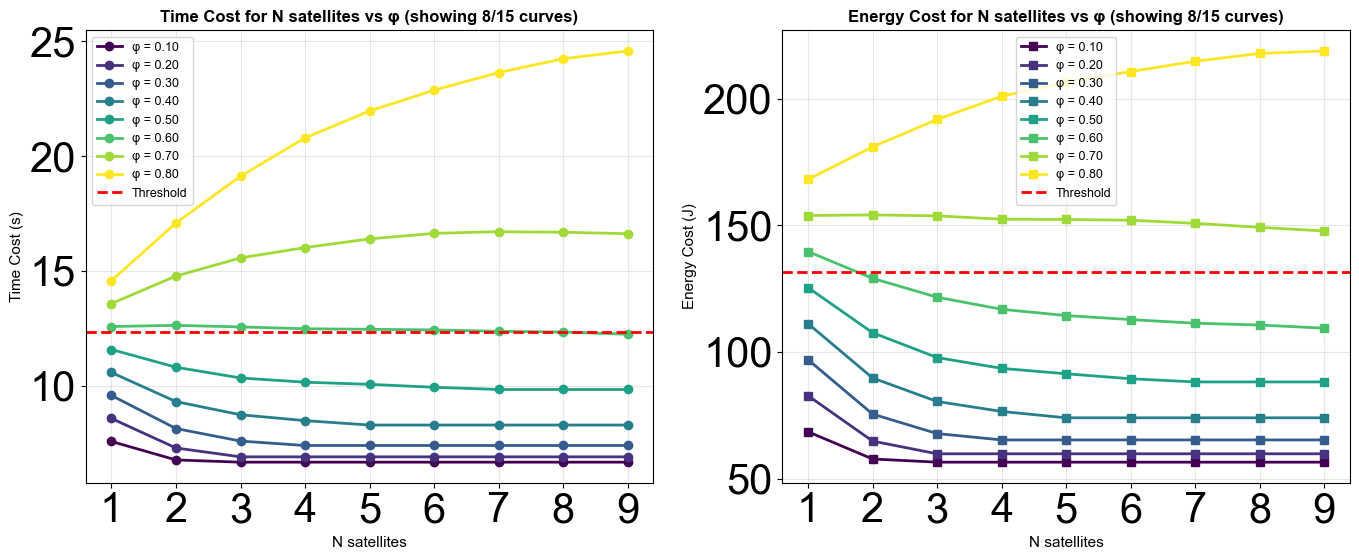

In [35]:
print(time_costs)
print(energy_costs)

# Convert to numpy arrays for easier indexing
time_costs_array = np.array(time_costs)
energy_costs_array = np.array(energy_costs)

# Option to display only the first n phi values
# n_phi_to_display = len(phi_values)  # Change this to display fewer curves (e.g., 3, 5, etc.)
n_phi_to_display = 8  # Uncomment and set to desired number

# Select phi values to display
phi_to_display = phi_values[:n_phi_to_display]

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Define colors for different phi values
colors = plt.cm.viridis(np.linspace(0, 1, len(phi_to_display)))

# First plot - Time Cost
for j in range(n_phi_to_display):
    phi_en = phi_values[j]
    ax1.plot(n_satellites, time_costs_array[:, j], marker='o',
             color=colors[j], label=f'φ = {phi_en:.2f}', linewidth=2)

ax1.axhline(y=base_time_cost, color='red', linestyle='--', linewidth=2, label='Threshold')
ax1.set_xlabel('N satellites', fontsize=11)
ax1.set_ylabel('Time Cost (s)', fontsize=11)
ax1.set_title(f'Time Cost for N satellites vs φ (showing {n_phi_to_display}/{len(phi_values)} curves)',
              fontsize=12, fontweight='bold')
ax1.set_xticks(n_satellites)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=9)

# Second plot - Energy Cost
for j in range(n_phi_to_display):
    phi_en = phi_values[j]
    ax2.plot(n_satellites, energy_costs_array[:, j], marker='s',
             color=colors[j], label=f'φ = {phi_en:.2f}', linewidth=2)

ax2.axhline(y=base_energy_cost, color='red', linestyle='--', linewidth=2, label='Threshold')
ax2.set_xlabel('N satellites', fontsize=11)
ax2.set_ylabel('Energy Cost (J)', fontsize=11)
ax2.set_title(f'Energy Cost for N satellites vs φ (showing {n_phi_to_display}/{len(phi_values)} curves)',
              fontsize=12, fontweight='bold')
ax2.set_xticks(n_satellites)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=9)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()